In [159]:
!cd ../src

zsh:cd:1: no such file or directory: ../src


In [160]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
%autoreload 2

In [162]:
import pandas as pd
import numpy as np
import spacy

In [163]:
nlp = spacy.load("en_core_web_lg")

### Parameters

In [164]:
from src.utils import plots_dir, clusters_dir, features_dir
import matplotlib.pyplot as plt

# Plots
font = {
    'size': 16
}
plt.rc('font', **font)

# Experiment
group = "controlled"  # "controlled" or "free" or "combined"
pos = "adjectives"  # "nouns" or "adjectives"

colors = {
    "controlled": "#97121f",
    "free": "#1271d1",
    "combined": "#0b4539"
}

# Embeddings
embeddings_model = "glove"  # "bert" or "glove"

# Clustering
if group == "controlled" and pos == "nouns":
    N_CLUSTERS = 9
if group == "controlled" and pos == "adjectives":
    N_CLUSTERS = 10
if group == "free" and pos == "nouns":
    N_CLUSTERS = 12
if group == "free" and pos == "adjectives":
    N_CLUSTERS = 11
if group == "combined" and pos == "nouns":
    N_CLUSTERS = 17
if group == "combined" and pos == "adjectives":
    N_CLUSTERS = 19

# Base output paths
base_filename = f"{group}_{pos}_2_{embeddings_model}_agglo"
plots_path = plots_dir() / base_filename
plots_path = str(plots_path)
clusters_path = clusters_dir() / base_filename
clusters_path = str(clusters_path) + f"_n{N_CLUSTERS}"
features_path = features_dir() / "linguistic" / base_filename
features_path = str(features_path) + f"_n{N_CLUSTERS}"

### Load descriptors

In [165]:
from src.utils import descriptors_dir

descriptors = np.genfromtxt(descriptors_dir() / f"{group}_{pos}.txt", dtype=str)
len(descriptors), list(descriptors)

(44,
 ['first',
  'rhythmic',
  'excited',
  'much',
  'other',
  'anxious',
  'different',
  'constant',
  'more',
  'like',
  'sweaty',
  'hard',
  'slow',
  'slight',
  'little',
  'pleasant',
  'sticky',
  'uncomfortable',
  'good',
  'long',
  'strong',
  'nice',
  'annoying',
  'small',
  'tiny',
  'same',
  'electrical',
  'last',
  'least',
  'bad',
  'actual',
  'smooth',
  'second',
  'super',
  'weird',
  'light',
  'similar',
  'sure',
  'soft',
  'satisfied',
  'subtle',
  'electric',
  'continuous',
  'low'])

### Get static embeddings for descriptors

In [166]:
if embeddings_model == "bert":
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
    embeddings = model.encode(descriptors, convert_to_numpy=True, show_progress_bar=True)
else:  # "glove"
    from src.glove import get_embeddings
    embeddings_dict = get_embeddings(n_dim=300)
    embeddings = np.array([embeddings_dict[word] for word in descriptors])

print(embeddings.shape)

(44, 300)


### Find best clustering

100%|██████████| 27/27 [00:00<00:00, 202.37it/s]


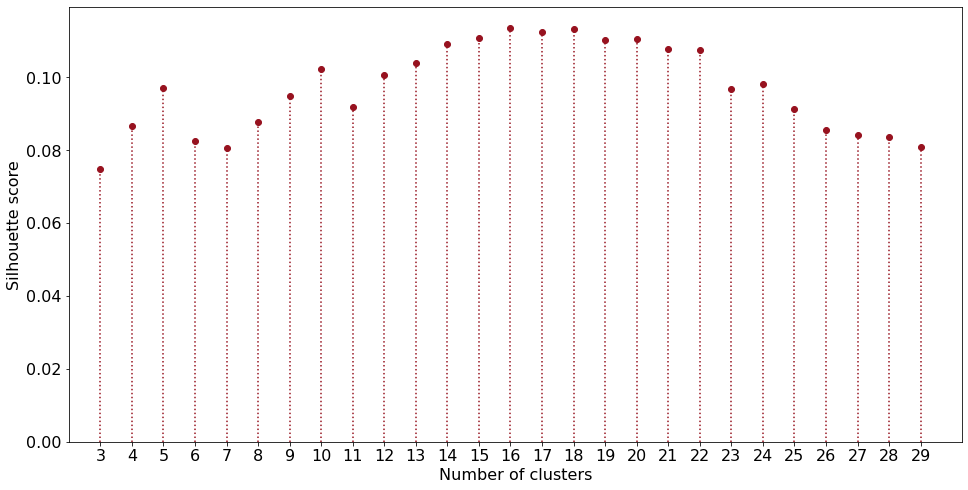

In [167]:
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

n_clusters = range(3, 30)
sl_scores = []

for n in tqdm(n_clusters):
    labels = AgglomerativeClustering(affinity="euclidean",
                                     n_clusters=n,
                                     linkage="ward"
                                     ).fit_predict(embeddings)
    sl_score = silhouette_score(embeddings, labels)
    sl_scores.append(sl_score)

plt.figure(figsize=(16, 8))
plt.scatter(n_clusters, sl_scores, color=colors[group])
for i, n in enumerate(n_clusters):
    plt.vlines(x=n, ymin=0, ymax=sl_scores[i], ls=":", colors=colors[group])
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.xlim(2)
plt.ylim(0)
plt.xticks(n_clusters)
plt.savefig(plots_path + "_silhouette_score.png",
            bbox_inches='tight',
            transparent=True,
            pad_inches=0,
            dpi=300)

### Compute clustering and store results in dicts

In [168]:
labels = AgglomerativeClustering(affinity="euclidean",
                                 n_clusters=N_CLUSTERS,
                                 linkage="ward"
                                 ).fit_predict(embeddings)

concept_to_desc = {} # k: concept_idx, v: list of descriptors
desc_to_concept = {} # k: desc_idx, v: concept_idx

for concept_idx in range(0, N_CLUSTERS):
    desc_indices = list(np.argwhere(labels == concept_idx))
    desc_indices = [desc_idx[0] for desc_idx in desc_indices]
    concept_to_desc[concept_idx] = [descriptors[desc_idx] for desc_idx in desc_indices]

    for desc_idx in desc_indices:
        desc_to_concept[desc_idx] = concept_idx

### Find cluster centers / concept representative


In [169]:
from sklearn.metrics.pairwise import euclidean_distances

concept_centers = []
for concept_idx in range(0, N_CLUSTERS):
    desc_indices = list(np.argwhere(labels == concept_idx))
    desc_indices = [desc_idx[0] for desc_idx in desc_indices]
    desc_embeddings = embeddings[desc_indices] # get embeddings for descriptors in concept
    distance_matrix = euclidean_distances(desc_embeddings, desc_embeddings) # compute distances
    summed_distance_matrix = np.sum(distance_matrix, axis=1) # sum up distances per descriptor
    min_idx = np.argmin(summed_distance_matrix) # find min overall distance
    concept_center_idx = desc_indices[min_idx]
    concept_centers.append(descriptors[concept_center_idx])

# np.savetxt(clusters_path + "_centers.csv", concept_centers, delimiter=",", fmt="%s")

### Plot dendrogram and save to disk

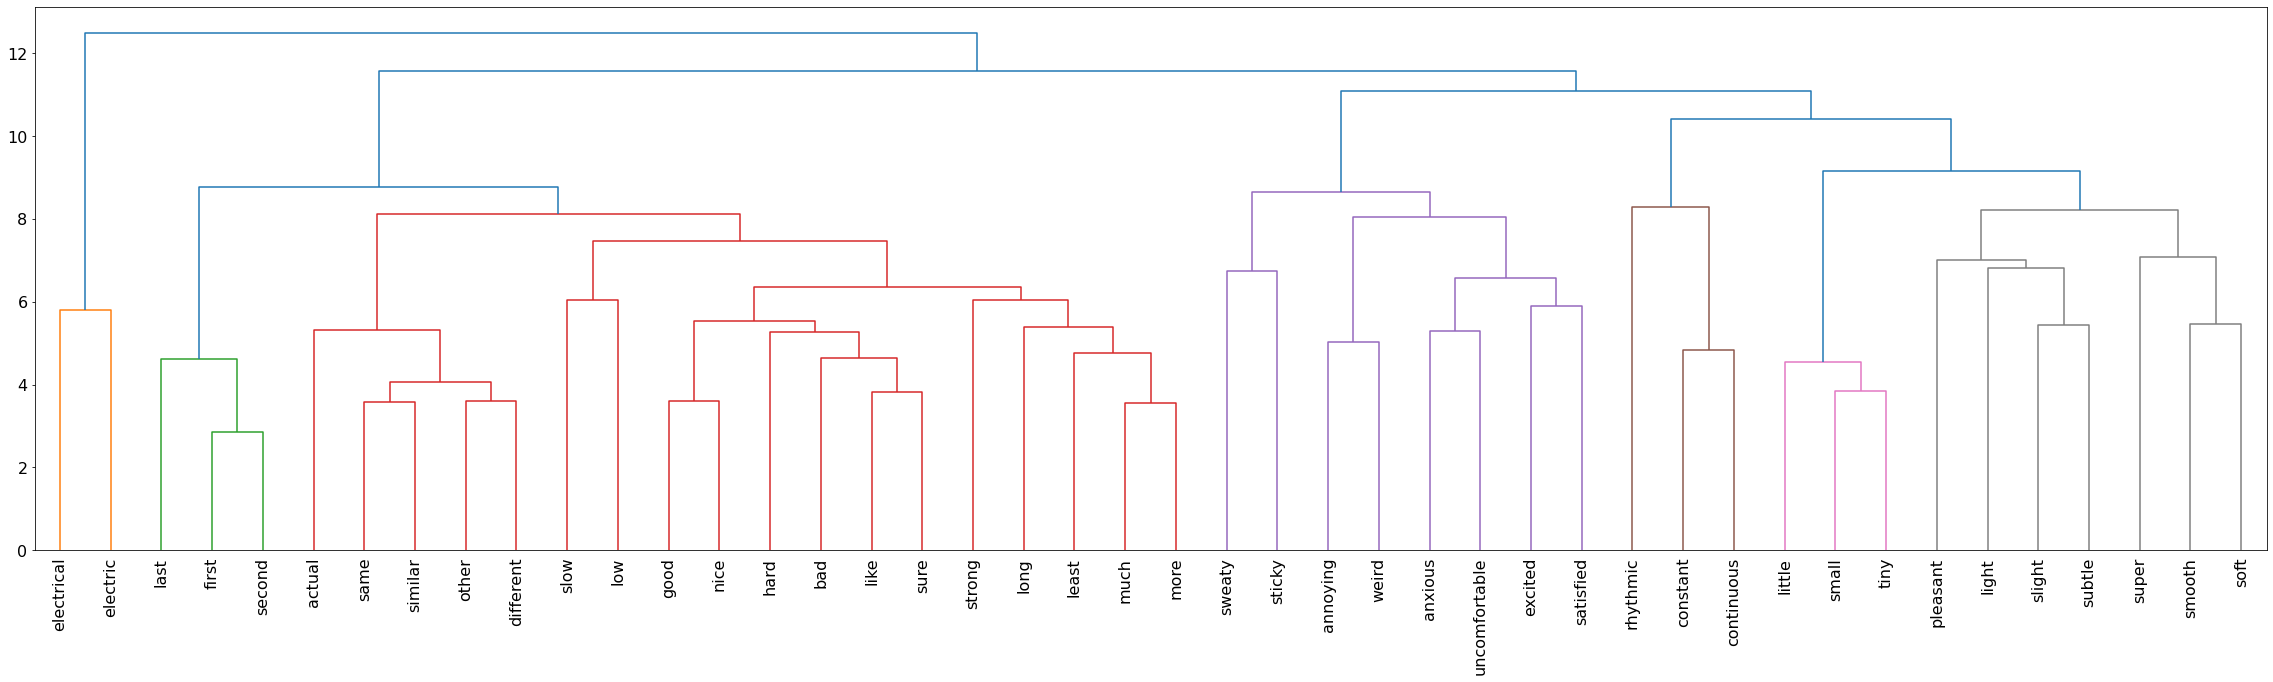

In [170]:
from scipy.cluster.hierarchy import dendrogram

model = AgglomerativeClustering(affinity="euclidean",
                                linkage="ward",
                                distance_threshold=0,
                                n_clusters=None)
model = model.fit(embeddings)

plt.figure(figsize=(40,10))

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
dendrogram(linkage_matrix,
           labels=descriptors,
           leaf_rotation=90.,
           leaf_font_size=font["size"])
plt.savefig(plots_path + "_dendrogram.png")

### Save clusters to disk (as JSON)

In [171]:
import json

# path = clusters_path + ".json"
# with open(path, "w") as fp:
#     json.dump(concept_to_desc, fp)
#
# print(f"See clusters at {path}")

### From clusters to concept matrix

1. Replace words in normalized pattern descriptions with the concept they are associated with.

In [172]:
from src.data import get_merged_norm_descriptions

merged_norm_descriptions = get_merged_norm_descriptions(group) # 32 patterns
concepts = []

for description in merged_norm_descriptions:
    concept_names = []
    for word in description.split():
        word_indices = np.where(np.array(descriptors) == word)[0]
        if len(word_indices) > 0:  # word is in descriptors
            word_idx = word_indices[0]
            concept_idx = desc_to_concept[word_idx]
            concept_name = f"concept_{concept_idx}"
            concept_names.append(concept_name)

    concepts.append(" ".join(concept_names))

### TF-IDF

1. Compute TF-IDF feature matrix on the new pattern descriptions that include concept ids instead of words.
2. Save feature matrix to disk.

In [173]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(concepts)

In [174]:
ids = [ [id] for id in range(1, 33) ]
features = X_tfidf.todense()
features = np.hstack((ids, features))
columns = ["id"]
for feature_name in vectorizer.get_feature_names_out():
    columns.append(feature_name)
df = pd.DataFrame(features, columns=columns)
df = df.round(4)
df = df.astype({ "id": int })
# df.to_csv(features_path + "_tfidf.csv", index=False)

### Count Vectorizer

1. Count occurrences of concepts.
2. Save feature matrix to disk.

In [175]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_count = vectorizer.fit_transform(concepts)

In [176]:
ids = [ [id] for id in range(1, 33) ]
features = X_count.todense()
features = np.hstack((ids, features))
columns = ["id"]
for feature_name in vectorizer.get_feature_names_out():
    columns.append(feature_name)
df = pd.DataFrame(features, columns=columns)
df = df.round(4)
df = df.astype({ "id": int })
df.to_csv(features_path + "_count.csv", index=False)